In [1]:
import os
import time

import requests
from tqdm import tqdm

In [10]:
def download_file_with_retry(
    url, destination, chunk_size=1024, max_retries=15, retry_delay=60, timeout=60
):
    retry_count = 0
    resume_header = {}
    if os.path.exists(destination):
        resume_header["Range"] = "bytes=%d-" % os.path.getsize(destination)

    while retry_count < max_retries:
        try:
            with requests.get(
                url, stream=True, headers=resume_header, timeout=timeout
            ) as response:
                response.raise_for_status()

                file_size = int(response.headers.get("content-length", 0))

                with open(destination, "ab") as file, tqdm(
                    total=file_size,
                    unit="B",
                    unit_scale=True,
                    unit_divisor=1024,
                    desc=os.path.basename(destination),
                ) as progress_bar:
                    for chunk in response.iter_content(chunk_size=chunk_size):
                        if chunk:
                            file.write(chunk)
                            progress_bar.update(len(chunk))

            print("Download complete!")

            return True

        except requests.exceptions.RequestException as e:
            print(f"Error occurred: {e}")

            retry_count += 1

            if retry_count < max_retries:
                print(f"Retrying download in {retry_delay} seconds...")
                time.sleep(retry_delay)

    print("Max retries reached. Download failed.")

    return False

In [11]:
# Example usage
file = "PointCloud_pt_zips/compressed_pcs_pt_06.zip"
url = f"https://huggingface.co/datasets/tiange/Cap3D/resolve/main/{file}?download=true"

destination = file

download_file_with_retry(url, destination, chunk_size=8192)

Error occurred: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /datasets/tiange/Cap3D/resolve/main/PointCloud_pt_zips/compressed_pcs_pt_06.zip?download=true (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x728ef9913c70>: Failed to resolve 'huggingface.co' ([Errno -3] Temporary failure in name resolution)"))
Retrying download in 60 seconds...


compressed_pcs_pt_06.zip:   0%|          | 13.8M/3.97G [01:15<6:07:10, 193kB/s] 


Error occurred: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.
Retrying download in 60 seconds...


compressed_pcs_pt_06.zip: 100%|██████████| 3.97G/3.97G [1:54:53<00:00, 619kB/s]   

Download complete!


True

In [3]:
import requests

file = "compressed_imgs_ABO.zip"
url = f"https://huggingface.co/datasets/tiange/Cap3D/resolve/main/misc/{file}?download=true"

destination = file


def download_file(url, local_filename, stream=True, chunk_size=8192):
    # NOTE the stream=True parameter below
    with requests.get(url, stream=stream) as r:

        r.raise_for_status()

        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                # if chunk:
                f.write(chunk)

    return local_filename

In [4]:
download_file(url=url, local_filename=destination)

'compressed_imgs_ABO.zip'

In [53]:
download = True
download_url = f"https://huggingface.co/datasets/tiange/Cap3D/{'resolve' if download else 'raw'}/main/misc/compressed_imgs_ABO.zip{'?download=true' if download else ''}"

download = False
pointer_url = f"https://huggingface.co/datasets/tiange/Cap3D/{'resolve' if download else 'raw'}/main/misc/compressed_imgs_ABO.zip{'?download=true' if download else ''}"

In [76]:
url.replace("resolve", "raw").split("?")[0]

'https://huggingface.co/datasets/tiange/Cap3D/raw/main/misc/compressed_imgs_ABO.zip'

In [6]:
download = True
d = requests.get(download_url)
d

<Response [200]>

In [56]:
dir(d)

['__attrs__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_content',
 '_content_consumed',
 '_next',
 'apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'next',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

In [59]:
d.status_code, type(d.content), d.content[:10]

(200, bytes, b'PK\x03\x04\x14\x00\x00\x00\x08\x00')

In [13]:
import hashlib


def sha256_hash(data: bytes):
    """
    Compute the SHA-256 hash of the given data.

    Args:
        data (bytes): The input data to be hashed.

    Returns:
        str: The hexadecimal representation of the SHA-256 hash.
    """
    sha256 = hashlib.sha256()
    sha256.update(data)
    return sha256.hexdigest()

In [60]:
sha256_hash(d.content)

'a7e8a8c4d9b7e4c3044a365915cfc0c50725e3ac94b137788addd91b7c34ad7f'

In [61]:
p = requests.get(pointer_url)
p

<Response [200]>

In [62]:
p.status_code, type(p.content), p.content[:10]

(200, bytes, b'version ht')

In [64]:
print(p.content.decode("utf-8"))

version https://git-lfs.github.com/spec/v1
oid sha256:a7e8a8c4d9b7e4c3044a365915cfc0c50725e3ac94b137788addd91b7c34ad7f
size 1228562479



In [65]:
from typing import List


def extract_sha256_from_pointer_file(bytes_data: bytes) -> str or None:
    """
    Extract the SHA256 hash from a bytes string.

    Args:
        bytes_data (bytes): The bytes string containing the data.

    Returns:
        str or None: The extracted SHA256 hash if found, otherwise None.
    """
    # Decode bytes to string
    data_str: str = bytes_data.decode("utf-8")

    # Split the string into lines
    lines: List[str] = data_str.split("\n")

    # Find the line containing the SHA256 hash
    sha256_line: str = next(
        (line for line in lines if line.startswith("oid sha256:")), None
    )

    # Extract the SHA256 hash value
    if sha256_line:
        sha256_hash: str = sha256_line.split("sha256:")[1]
        return sha256_hash
    else:
        return None

In [66]:
extract_sha256_from_pointer_file(bytes_data=p.content)

'a7e8a8c4d9b7e4c3044a365915cfc0c50725e3ac94b137788addd91b7c34ad7f'

In [67]:
def calculate_file_hash(file_path: str) -> str:
    """
    Calculate the SHA256 hash of a file.

    Args:
        file_path (str): The path to the file.

    Returns:
        str: The hexadecimal representation of the SHA256 hash.
    """
    # Read the file's bytes
    with open(file_path, "rb") as file:
        file_bytes: bytes = file.read()

    # Calculate the SHA256 hash of the file's bytes
    file_hash: str = sha256_hash(file_bytes)

    return file_hash

In [71]:
file_path = "misc/compressed_imgs_ABO.zip"
calculate_file_hash(file_path=file_path)

'a7e8a8c4d9b7e4c3044a365915cfc0c50725e3ac94b137788addd91b7c34ad7f'

In [72]:
def perform_checksum(file_path: str, pointer_file_url: str) -> bool:
    """TODO: Add docstring"""
    file_hash: str = calculate_file_hash(file_path=file_path)

    response = requests.get(pointer_file_url)
    response.raise_for_status()

    pointer_file: bytes = response.content

    expected_hash: str = extract_sha256_from_pointer_file(bytes_data=pointer_file)

    return file_hash == expected_hash

In [73]:
perform_checksum(file_path=file_path, pointer_file_url=pointer_url)

True

In [20]:
12000 * 8000

96000000

/home/yunusskeete/miniconda3/envs/3d/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


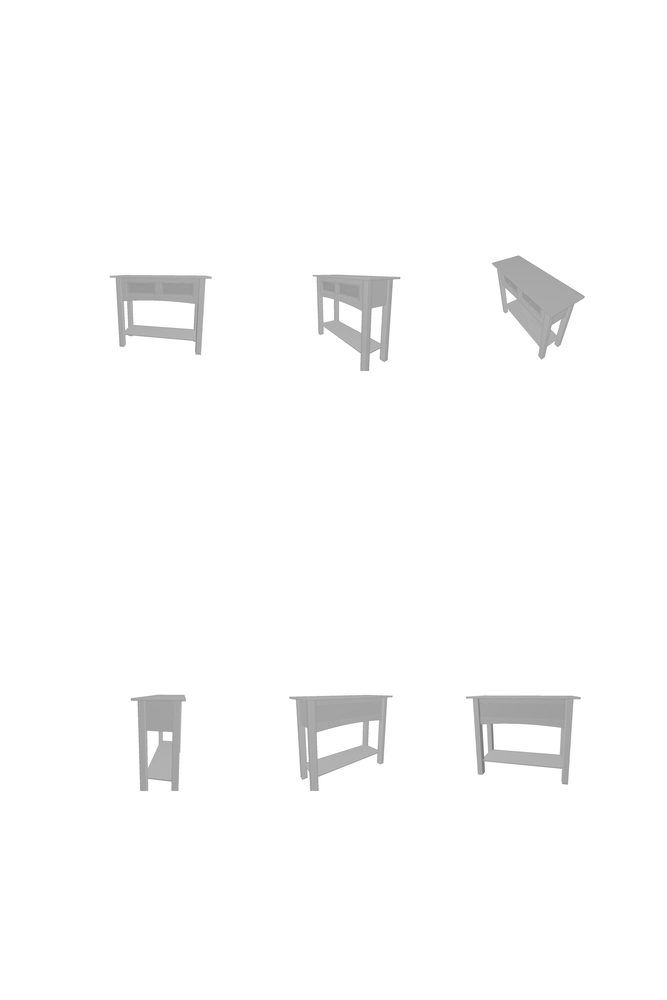

In [19]:
from PIL import Image
from IPython.display import display

image_path = "misc/ABO_imgs_6views/B00BBDF500"
image = Image.open(image_path)

# Resize the image while maintaining aspect ratio
max_width = 1000  # Set the maximum width
max_height = 1000  # Set the maximum height
image.thumbnail((max_width, max_height), Image.LANCZOS)

display(image)